In [1]:
import pickle
import random
import nltk
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import zipfile
import gensim
from tensorflow import keras
import tensorflow as tf
import json
import os
import tweepy as tw

In [2]:
with open('vectors.pkl', 'rb') as f:
    vectors = pickle.load(f)
    
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2, random_state=42, stratify=labels)

x_train = np.array(x_train)

In [4]:
y_train[:5]

[5, 1, 6, 0, 2]

In [5]:
class EmotionModel(tf.keras.Model):
    def __init__(self):
        super(EmotionModel, self).__init__()
        self.fc1 = tf.keras.layers.Dense(units=64, activation='relu')
        self.fc2 = tf.keras.layers.Dense(units=128, activation='relu')
        self.fc4 = tf.keras.layers.Dense(units=7, activation='softmax')
    
    def call(self, inputs, test=False):
        x = self.fc1(inputs)
        x = self.fc2(x)
        return self.fc4(x)
    
    def fit(self, data, **kwargs):
        
        optimizer = kwargs.get('optimizer', tf.keras.optimizers.Adam())
        loss_fn = kwargs.get('loss_func', tf.keras.losses.SparseCategoricalCrossentropy())
        epochs = kwargs.get('epochs', 10)
        batch = kwargs.get('batch', 100)
        
        train_dataset = tf.data.Dataset.from_tensor_slices(data)
        train_dataset = train_dataset.shuffle(buffer_size=len(data[0])).batch(batch_size=batch)
        
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        train_losses = []
        train_accuracies = []

        for epoch in range(epochs):
            print('Start of epoch %d' % (epoch))
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

                with tf.GradientTape() as tape:
                    predictions = self.call(x_batch_train)
                    loss_value = loss_func(y_batch_train, predictions)

                grads = tape.gradient(loss_value, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                
                train_loss(loss_value)
                train_accuracy(y_batch_train, predictions)
        
            print(f'Loss: {train_loss.result().numpy()} Accuracy: {train_accuracy.result().numpy()}')
            
            train_losses.append(train_loss.result())
            train_accuracies.append(train_accuracy.result())
            
            train_loss.reset_states()
            train_accuracy.reset_states()
            
        return train_losses, train_accuracies

    def predict(self, x):
        batches = tf.data.Dataset.from_tensor_slices(x).batch(batch_size=200)
        results = [np.array(self.call(batch, test=True)) for batch in batches]
        result = []
        for res in results:
            result.extend(res)
        return np.argmax(result, axis=1)

In [6]:
%%time

optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
model = EmotionModel()

loss, acc = model.fit((x_train, y_train), optimizer=optimizer, loss_func=loss_func, epochs=20)

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Loss: 1.917728304862976 Accuracy: 0.24197861552238464
Start of epoch 1
Loss: 1.7344363927841187 Accuracy: 0.36213234066963196
Start of epoch 2
Loss: 1.5539469718933105 Accuracy: 0.4211229979991913
Start of epoch 3
Loss: 1.4579635858535767 Accuracy: 0.4476938545703888
Start of epoch 4
Loss: 1.4022815227508545 Accuracy: 0.47627004981040955
Start of epoch 5
Loss: 1.3570342063903809 Accuracy: 0.490307480096817
Start of epoch 6
Loss: 1.3222312927246094 Accuracy: 0.5091911554336548
Start of e

In [7]:
labels_text = ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']

def evaluate(labels_true, labels_predicted):
    accuracy = metrics.accuracy_score(y_true=labels_true, y_pred=labels_predicted)
    precision = metrics.precision_score(y_true=labels_true, y_pred=labels_predicted, average='micro')
    recall = metrics.recall_score(y_true=labels_true, y_pred=labels_predicted, average='micro')
    f1 = metrics.f1_score(y_true=labels_true, y_pred=labels_predicted, average='micro')

    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_test, y_pred):
    conf_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

    fig, ax = plt.subplots(figsize=(10, 8))   
    ax = sns.heatmap(conf_matrix, cmap="PiYG", annot=True, center=0)
    ax.yaxis.set_ticklabels(labels_text, rotation=0, ha='right', fontsize=14)
    ax.xaxis.set_ticklabels(labels_text, rotation=45, ha='right', fontsize=14)

In [8]:
y_pred = model.predict(x_test)

In [9]:
evaluate(y_pred, y_test)

(0.5240641711229946,
 0.5240641711229946,
 0.5240641711229946,
 0.5240641711229946)

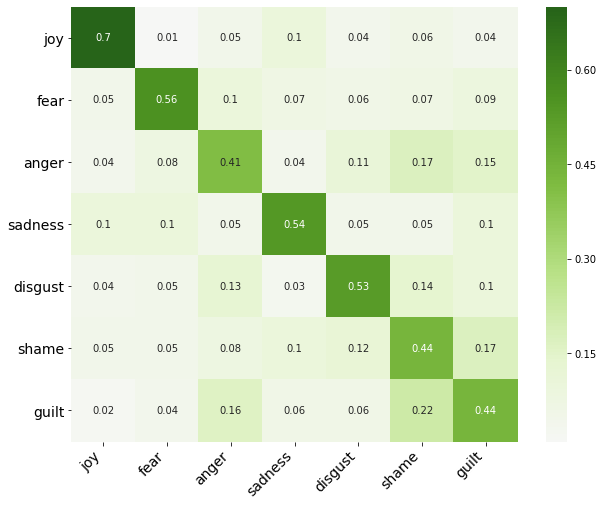

In [10]:
plot_confusion_matrix(y_pred, y_test)

# Verification

In [11]:
with open('tweets_vectors.pkl', 'rb') as f:
    tweets_vectors = pickle.load(f)
    
with open('tweets_labels.pkl', 'rb') as f:
    tweets_labels = pickle.load(f)

In [12]:
tweets_pred = model.predict(tweets_vectors)

In [13]:
evaluate(tweets_pred, tweets_labels)

(0.6085714285714285,
 0.6085714285714285,
 0.6085714285714285,
 0.6085714285714285)

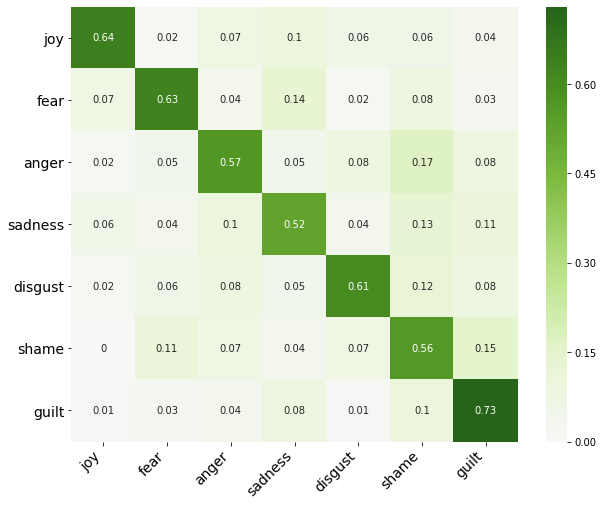

In [14]:
plot_confusion_matrix(tweets_pred, tweets_labels)

In [20]:
import random

def count_prob(tab):
    num_classes = len(tab)
    s = sum(tab)
    acc = 0
    # acc = P(class=0) * P(prediction=0) + P(class=1) * P(prediction=1)
    # P(prediction=0) = P(class=0)
    for el in tab:
        acc += el/s * el/s
    return acc


print(count_prob([1, 1, 1, 1, 9]))
print(count_prob([1, 9, 9, 9, 9]))
print(count_prob([5, 5, 5, 5, 5]))
print(count_prob([3, 5, 7, 4, 2]))
print(count_prob([1, 1, 1, 1, 1]))
print(count_prob([1, 1, 100, 1, 1]))

0.5029585798816568
0.23739956172388604
0.2
0.2335600907029478
0.2
0.9249260355029587


In [27]:
import pickle
import numpy as np

with open('raw.pickle', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    data = u.load()
    
labels = [np.argmax(el['label']) for el in data['info']]
cnt = [labels.count(label) for label in [0, 1, 2, 3, 4, 5, 6]]


In [28]:
cnt

[1084, 1078, 1080, 1079, 1057, 1045, 1057]

In [29]:
print(count_prob(cnt))

0.1428819811833338
